Import mnist images and binarize

In [233]:
import mnist
import scipy.misc
images = mnist.train_images()
orig_images = images[0:20][:][:].astype(float)
orig_images[orig_images<128] = -1
orig_images[orig_images>127] = 1

Read noise coordinates file and save in array flipvalues. Flip pixels as per noise coordinates

In [236]:
import csv
with open('SupplementaryAndSampleData/NoiseCoordinates.csv','r') as noisefile:
          csvreader = csv.reader(noisefile)
          next(csvreader)
          flipvalues = []
          for row in csvreader:
              flipvalues.append([int(i) for i in row[1:]])
            
# flip pixels as indicated in NoiseCordinates.csv

x = orig_images
imagenum = 0
for rownum in range(0,40,2):
    for colnum in range(0,15):
        x[imagenum][flipvalues[rownum][colnum]][flipvalues[rownum+1][colnum]] *= -1
    imagenum+=1

In [308]:
# display first noisy image
scipy.misc.toimage(scipy.misc.imresize(x * -1 + 256, 10.))

ValueError: 'arr' does not have a suitable array shape for any mode.

Read UpdateOrderCoordinates and save into dictionary orderdict

In [241]:
import numpy as np
with open('SupplementaryAndSampleData/UpdateOrderCoordinates.csv','r') as orderfile:
          csvreader = csv.reader(orderfile)
          next(csvreader)
          orderdata = []
          for row in csvreader:
              orderdata.append([int(i) for i in row[1:]])
orderdata = np.array(orderdata)

# create dictionary where key = image+number and value = dictionary of {pixel:(row,col)} pairs
orderdict = {}
for row in range(0,40,2):
    orderdict['image'+str(int(row/2))] = {}
    for col in range(0,784):
        orderdict['image'+str(int(row/2))][col] = (orderdata[row][col],orderdata[row+1][col])
print(orderdict.keys())

Read InitialParametersModel.csv into numpy array pidata

In [256]:
with open('SupplementaryAndSampleData/InitialParametersModel.csv','r') as pifile:
          csvreader = csv.reader(pifile)
          pidata = []
          for row in csvreader:
              pidata.append([float(i) for i in row])
pidata = np.array(pidata)
print(pidata.shape)

(28, 28)


In [245]:
# Function to return list of neighbours given indices of a pixel

def get_neighbours(r,c):
    neighbours = []
    if (r == 0 and c == 0):
        neighbours = [(r,c+1),(r+1,c)] 
    elif (r == 27 and c == 27):
        neighbours = [(r-1,c),(r,c-1)]
    elif (r == 27 and c == 0):
        neighbours = [(r-1,c),(r,c+1)]
    elif (r == 0 and c == 27):
        neighbours = [(r,c-1),(r+1,c)]
    elif (r == 0):
        neighbours = [(r,c-1),(r,c+1),(r+1,c)] 
    elif (c == 0):
        neighbours = [(r-1,c),(r+1,c),(r,c+1)]
    elif (r == 27):
        neighbours = [(r,c-1),(r,c+1),(r-1,c)]
    elif (c == 27):
        neighbours = [(r,c-1),(r-1,c),(r+1,c)]
    else:
        neighbours = [(r-1,c),(r+1,c),(r,c-1),(r,c+1)]
    return neighbours

In [246]:
# F

def logqsum1(r,c,pi,theta):
    neighbours = get_neighbours(r,c)
    sum = 0
    for (row,col) in neighbours:
        sum += (theta * (2*pi[row][col] - 1))
    return sum

In [247]:
def logqsum2(image,r,c,x,theta):
    sum = theta * x[image][r][c]   
    return sum

In [222]:
def get_expctlogphx(pi0,image,x,thetahh,thetahx):
    expctlogphx = 0
    for r in range(0,28):
        for c in range(0,28):
            sum1 = 0
            neighbours = get_neighbours(r,c)
            for (row,col) in neighbours:
                sum1+= (thetahh*(2*pi0[r][c]-1)*(2*pi0[row][col]-1))
            sum1 += (thetahx * (2*pi0[r][c] - 1) * x[image][r][c])
            expctlogphx += sum1
    return expctlogphx

In [224]:
def get_expctlogq(pi0):
    expctlogq = 0.0
    epsilon = 10**(-10)
    for r in range(0,28):
        for c in range(0,28):
            expctlogq += ((pi0[r][c]*np.log(pi0[r][c]+epsilon)) + ((1-pi0[r][c])*np.log((1-pi0[r][c])+epsilon)))
    return expctlogq

Compute variational free energy after each iteration using functions defined above. Compute denoised pixels for images 11 to 20.

In [295]:
from copy import deepcopy
thetahh = 0.8
thetahx = 2.0
vfe = np.zeros((20,11))
denoised = np.zeros((28,560))
for image in range(0,20):
    pi = deepcopy(pidata)
    for i in range(0,11):
        expctlogq = get_expctlogq(pi)
        expctlogphx = get_expctlogphx(pi,image,x,thetahh,thetahx)
        energy  = expctlogq - expctlogphx
        vfe[image][i] = energy
        if i == 10:
            break
        for pixel in range(0,784):
            r = orderdict['image'+str(image)][pixel][0]
            c = orderdict['image'+str(image)][pixel][1]
            logqi1 = logqsum1(r,c,pi,thetahh) + logqsum2(image,r,c,x,thetahx)
            logqi_1 = logqsum1(r,c,pi,-thetahh) + logqsum2(image,r,c,x,-thetahx)
            pi[r][c] = np.exp(logqi1)/(np.exp(logqi1) + np.exp(logqi_1))
    pi[pi>0.5] = 1
    pi[pi<=0.5] = 0
    if image == 10:
        denoised = pi
    else:
        if image>10:
            denoised = np.hstack((denoised,pi))                                                                                                                                                                                                                                                                                   
#print(vfe)
np.savetxt('vfevalues.csv', vfe, delimiter=',', fmt='%s')
np.savetxt('denoised.csv', denoised, delimiter=',', fmt='%s')
print('done')

done


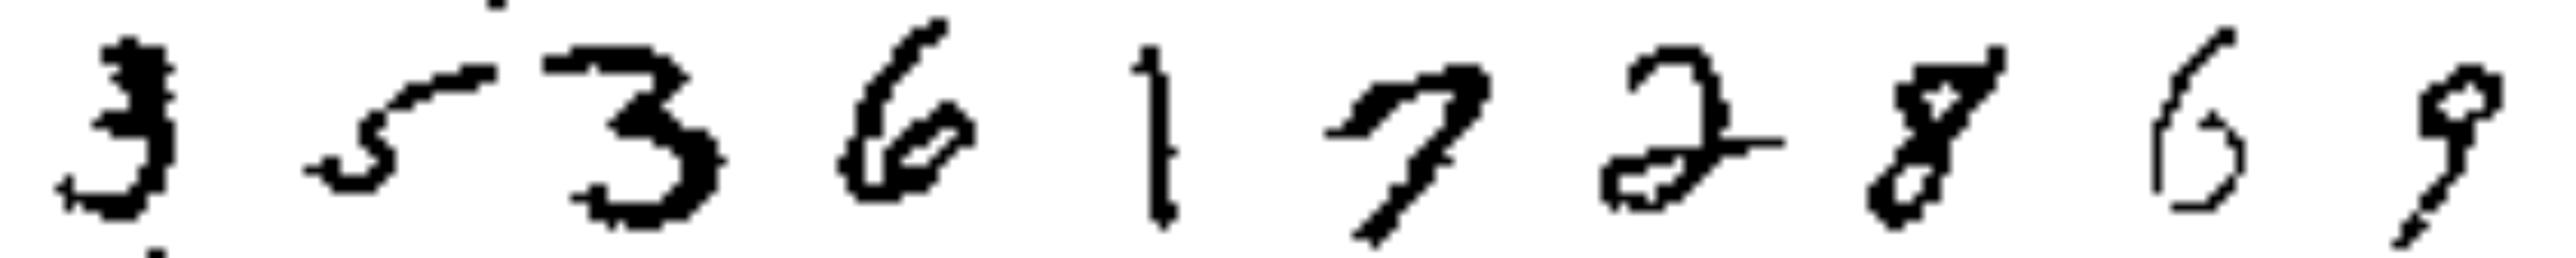

In [296]:
# print denoised images 11 to 20.
scipy.misc.toimage(scipy.misc.imresize(denoised * -1 + 256, 10.))

In [306]:
# Compute FPR and TPR
thetahh = 0.8
c = [5,3,2,1,0.6,0.4,0.35,0.3,0.1]
for thetahx in c:
    tp = fp = fn = tn = 0
    for image in range(10,20):
        pi = deepcopy(pidata)
        for i in range(0,10):
            for pixel in range(0,784):
                r = orderdict['image'+str(image)][pixel][0]
                c = orderdict['image'+str(image)][pixel][1]
                logqi1 = logqsum1(r,c,pi,thetahh) + logqsum2(image,r,c,x,thetahx)
                logqi_1 = logqsum1(r,c,pi,-thetahh) + logqsum2(image,r,c,x,-thetahx)
                pi[r][c] = np.exp(logqi1)/(np.exp(logqi1) + np.exp(logqi_1))
        pi[pi>0.5] = 1
        pi[pi<=0.5] = -1
        for row in range(0,28):
            for col in range(0,28):
                if pi[row][col] == 1 and orig_images[image][row][col] == 1:
                    tp+=1
                elif pi[row][col] == 1 and orig_images[image][row][col] == -1:
                    fp+=1
                elif pi[row][col] == -1 and orig_images[image][row][col] == 1:
                    fn+=1
                else:
                    tn+=1
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    print(fpr,tpr)
print('done')

0.0 1.0
0.0007331378299120235 0.9117647058823529
0.0007331378299120235 0.8901960784313725
0.005278592375366569 0.796078431372549
0.003812316715542522 0.5088235294117647
0.003812316715542522 0.307843137254902
0.0021994134897360706 0.2372549019607843
0.0021994134897360706 0.2019607843137255
0.17697947214076246 0.25392156862745097
done
